In [44]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

import os
import sys

sys.path.append("../src")

import geopandas as gpd
import requests as r
from owslib.wms import WebMapService
from shapely.geometry import LineString, MultiPolygon, Point, Polygon

from modelling.helpers import polygon_to_yolo_segmentation
from osm.queries import get_street_query, get_wildlife_crossing_query
from wms.get_wms_crops import get_crop_bboxes

In [45]:
streets_gdf = gpd.read_file("../data/geodata/CH_highway_depth_1.geojson")
streets_gdf.head()

,id,destination,highway,oneway,ref,surface,lanes,maxspeed,source:maxspeed,name,...,maxspeed:advisory,maxwidth,turn:bus:lanes,motorway,man_made,reg_ref,lanes:conditional,lanes:bus,cycleway:right:lane,geometry
0,78216,Interlaken; Kandersteg; Zweisimmen,motorway_link,yes,A6,asphalt,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4137546 2628376.755, 4137548.517 2..."
1,728458,Thun;Gunten,motorway_link,yes,None,asphalt,1,60,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4137667.053 2628425.539, 4137679.2..."
2,728459,Bern,motorway_link,yes,None,asphalt,None,60,sign,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4137790.097 2628490.163, 4137787.5..."
3,1906674,None,motorway_link,yes,None,asphalt,1,60,None,Wilderswil,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4157675.949 2620062.873, 4157688.7..."
4,1906703,Wilderswil;Grindelwald;Lauterbrunnen;Matten,motorway_link,yes,None,None,1,100,None,Wilderswil,...,None,None,None,None,None,None,None,None,None,"LINESTRING (4157432.136 2619924.41, 4157454.50..."


In [46]:
# get 5 longest street segments
streets_gdf["length"] = streets_gdf.geometry.length
longest_streets = streets_gdf.nlargest(5, "length")

<Axes: >

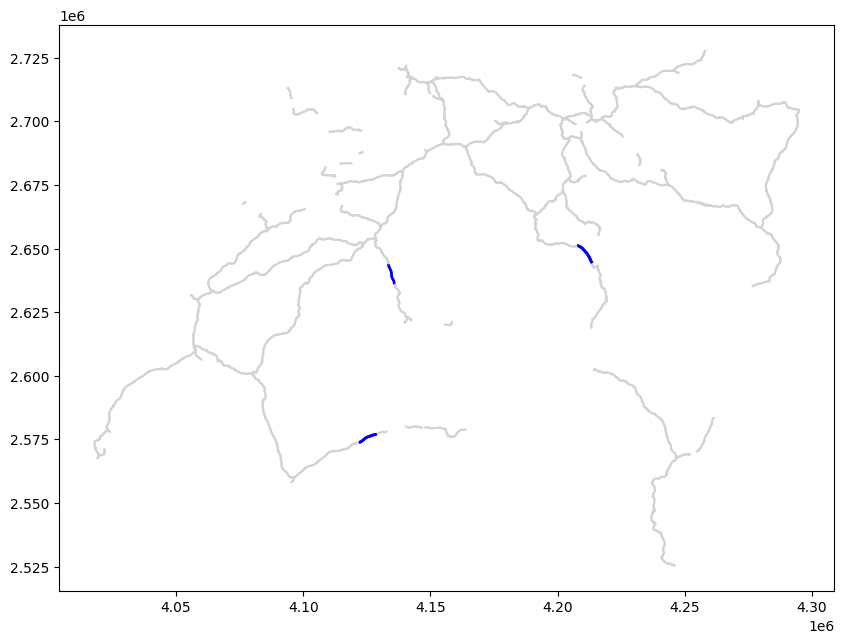

In [47]:
# plot longest street segments on map
ax = streets_gdf.plot(color="lightgray", figsize=(10, 10))
longest_streets.plot(ax=ax, color="blue", linewidth=2)

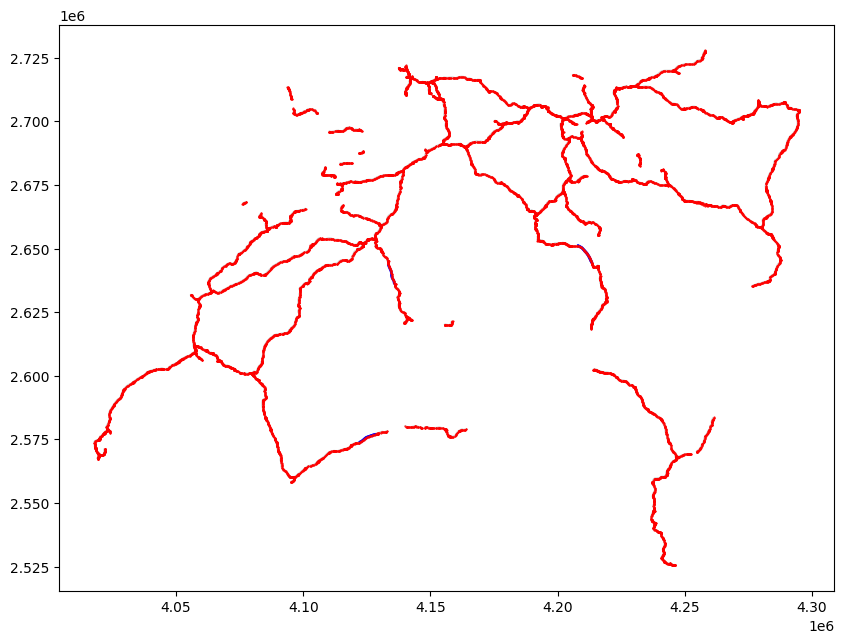

In [55]:
# sample a point along each of the longest street segments
sampled_points = []
for _, row in streets_gdf.iterrows():
    line = row.geometry
    
    # every 500m along the line sample a point
    for dist in range(0, int(line.length), 500):
        point = line.interpolate(dist)
        sampled_points.append(point)

# plot sampled points on map
ax = streets_gdf.plot(color="lightgray", figsize=(10, 10))
longest_streets.plot(ax=ax, color="blue", linewidth=2)
for point in sampled_points:
    plt.plot(point.x, point.y, marker="o", color="red", markersize=0.5)

In [59]:
len(sampled_points)

18121

In [49]:
# these typically do not need to be changed
OVERPASS_API_URL = "https://overpass-api.de/api/interpreter"
WMS_URL = "https://image.discomap.eea.europa.eu/arcgis/services/GioLand/VHR_2021_LAEA/ImageServer/WMSServer/?request=GetCapabilities&service=WMS"
CRS = "EPSG:3035"  # ETRS89 / ETRS-LAEA
PIXEL_RESOLUTION_M = 2  # 2 meters per pixel

In [50]:
wms = WebMapService(
    WMS_URL,
    version="1.3.0",
)
layer_name = list(wms.contents)[0]
print(layer_name)

VHR_2021_LAEA


In [56]:
gdf_points = gpd.GeoDataFrame(geometry=sampled_points, crs="EPSG:3035")
gdf_centroids = gdf_points.copy()
gdf_centroids["geometry"] = gdf_centroids.geometry.centroid

In [57]:
areas_of_interest = get_crop_bboxes(gdf_centroids, buffer_size)
# select  50 random sampmles from areas_of_interest
import random
areas_of_interest = random.sample(areas_of_interest, 50)

In [58]:
os.makedirs(output_dir, exist_ok=True)

# for every point create a square around it and request a WMS crop centered on the point
img_format = "image/png"
img_size = (
    int(buffer_size * 2 / pixel_size),
    int(buffer_size * 2 / pixel_size),
)  # width, height in pixels

for idx, bbox in enumerate(areas_of_interest):
    # Request WMS image
    img = wms.getmap(
        layers=[layer_name],
        srs="EPSG:3035",
        bbox=bbox,
        size=img_size,
        format=img_format,
        transparent=True,
    )

    # Save image to file
    img_data = img.read()
    img_filename = os.path.join(output_dir, f"street_img_{idx}.png")
    with open(img_filename, "wb") as f:
        f.write(img_data)